# 📁 Descargar los Datos

In [22]:
from dotenv import load_dotenv
import os
import boto3

In [23]:
load_dotenv()

AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')
BUCKET_NAME = 'anyoneai-datasets'
PREFIX = 'credit-data-2010/'

s3 = boto3.client('s3', 
                  aws_access_key_id=AWS_ACCESS_KEY_ID,
                  aws_secret_access_key=AWS_SECRET_ACCESS_KEY)

response = s3.list_objects_v2(Bucket=BUCKET_NAME, Prefix=PREFIX)

download_dir = os.path.join('..', 'data', 'raw')
os.makedirs(download_dir, exist_ok=True)

for obj in response.get('Contents', []):
    file_key = obj['Key']
    file_name = file_key.split('/')[-1]
    if file_name:
        dest_path = os.path.join(download_dir, file_name)
        print(f'Downloading {file_name} to {dest_path}...')
        s3.download_file(BUCKET_NAME, file_key, dest_path)

# 👀 Exploración de datos

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

In [25]:
# Visual settings
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)

In [26]:
# Paths to the downloaded files
var_names_path = os.path.join(download_dir, 'PAKDD2010_VariablesList.XLS')
train_path = os.path.join(download_dir, 'PAKDD2010_Modeling_Data.txt')

# Load variable names
variables_df = pd.read_excel(var_names_path)

col_names = variables_df['Var_Title'].astype(str).tolist()

col_names = (
  pd.Series(col_names)
    .str.strip()
    .str.replace(' ', '_')
    .str.replace('=', '_', regex=False)
    .str.replace('-', '_', regex=False)
    .str.upper()
    .tolist()
)

col_names[43] = 'MATE_EDUCATION_LEVEL'  # Correcting specific column name

df_train = pd.read_csv(
    train_path,
    sep='\t',
    encoding='latin1',
    header=None,
    names=col_names,
    low_memory=False
)

In [27]:
df_train.head()

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD_1
0,1,C,5,Web,0,1,F,6,1,0,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,...,0,0,0,0,1,N,48,235,235,1


In [28]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID_CLIENT                       50000 non-null  int64  
 1   CLERK_TYPE                      50000 non-null  object 
 2   PAYMENT_DAY                     50000 non-null  int64  
 3   APPLICATION_SUBMISSION_TYPE     50000 non-null  object 
 4   QUANT_ADDITIONAL_CARDS          50000 non-null  int64  
 5   POSTAL_ADDRESS_TYPE             50000 non-null  int64  
 6   SEX                             50000 non-null  object 
 7   MARITAL_STATUS                  50000 non-null  int64  
 8   QUANT_DEPENDANTS                50000 non-null  int64  
 9   EDUCATION_LEVEL                 50000 non-null  int64  
 10  STATE_OF_BIRTH                  50000 non-null  object 
 11  CITY_OF_BIRTH                   50000 non-null  object 
 12  NACIONALITY                     

In [29]:
df_train.describe()

,ID_CLIENT,PAYMENT_DAY,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,NACIONALITY,RESIDENCE_TYPE,MONTHS_IN_RESIDENCE,...,OCCUPATION_TYPE,MATE_PROFESSION_CODE,MATE_EDUCATION_LEVEL,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,AGE,TARGET_LABEL_BAD_1
count,50000.000000,50000.000000,50000.0,50000.000000,50000.00000,50000.000000,50000.0,50000.000000,48651.000000,46223.000000,...,42687.000000,21116.000000,17662.000000,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.00000,50000.000000
mean,25000.500000,12.869920,0.0,1.006540,2.14840,0.650520,0.0,0.961600,1.252225,9.727149,...,2.484316,3.797926,0.296003,0.0,0.0,0.0,0.0,1.275700,43.24852,0.260820
std,14433.901067,6.608385,0.0,0.080606,1.32285,1.193655,0.0,0.202105,0.867833,10.668841,...,1.532261,5.212168,0.955688,0.0,0.0,0.0,0.0,0.988286,14.98905,0.439086
min,1.000000,1.000000,0.0,1.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,6.00000,0.000000
25%,12500.750000,10.000000,0.0,1.000000,1.00000,0.000000,0.0,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,31.00000,0.000000
50%,25000.500000,10.000000,0.0,1.000000,2.00000,0.000000,0.0,1.000000,1.000000,6.000000,...,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,41.00000,0.000000
75%,37500.250000,15.000000,0.0,1.000000,2.00000,1.000000,0.0,1.000000,1.000000,15.000000,...,4.000000,11.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,53.00000,1.000000
max,50000.000000,25.000000,0.0,2.000000,7.00000,53.000000,0.0,2.000000,5.000000,228.000000,...,5.000000,17.000000,5.000000,0.0,0.0,0.0,0.0,7.000000,106.00000,1.000000


In [30]:
#Null values check
null_counts = df_train.isnull().sum()
null_percent = (null_counts / len(df_train)) * 100

null_summary = pd.DataFrame({
    'Missing_Count': null_counts,
    'Missing_Percent': null_percent.round(2)
})

null_summary = null_summary[null_summary['Missing_Count'] > 0].sort_values(by='Missing_Percent', ascending=False)

print("📊 Columns with missing values:")
print(null_summary)

📊 Columns with missing values:
                      Missing_Count  Missing_Percent
PROFESSIONAL_BOROUGH          33783            67.57
PROFESSIONAL_CITY             33783            67.57
MATE_EDUCATION_LEVEL          32338            64.68
MATE_PROFESSION_CODE          28884            57.77
PROFESSION_CODE                7756            15.51
OCCUPATION_TYPE                7313            14.63
MONTHS_IN_RESIDENCE            3777             7.55
RESIDENCE_TYPE                 1349             2.70


In [31]:
#Duplicate rows check
duplicate_count = df_train.duplicated().sum()
print("Duplicate rows in the training set:", duplicate_count)

Duplicate rows in the training set: 0


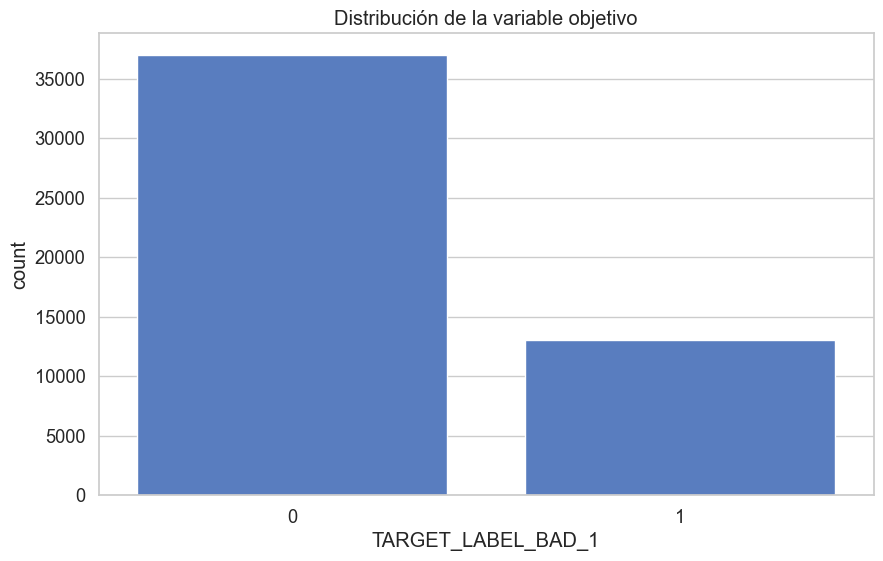

In [32]:
sns.countplot(x="TARGET_LABEL_BAD_1", data=df_train)
plt.title("Distribución de la variable objetivo")
plt.show()

In [33]:
print(df_train["TARGET_LABEL_BAD_1"].value_counts(normalize=True))

TARGET_LABEL_BAD_1
0    0.73918
1    0.26082
Name: proportion, dtype: float64
